**Deep Fake:**

Introduction: Deepfake Al is a type of artificial intelligence used to create convincing images, audio and video hoaxes. The term describes both the technology and the resulting bogus content and is a portmanteau of deep learning and fake. Deepfakes often transform existing source content where one person is swapped for another. They also create entirely original content where someone is represented doing or saying something they didn't do or say. The greatest danger posed by deepfakes is their ability to spread false information that appears to come from trusted sources.

Task: Create a classifier that can distinguish between real and fake images.

Data Link: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images

In [ ]:
cd /content/drive/MyDrive/project1

/content/drive/MyDrive/project1


In [ ]:
!pip install torch transformers==4.18.0 evaluate datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 45.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (

In [ ]:
#!unzip /content/drive/MyDrive/project1/part.zip -d data


In [ ]:
from datasets import load_dataset

# load the custom dataset
ds = load_dataset("imagefolder", data_dir="/content/drive/MyDrive/project1/data")
ds

Resolving data files:   0%|          | 0/4984 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5428 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4984
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5428
    })
})

In [ ]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['Fake', 'Real'], id=None)

In [ ]:
import random
import matplotlib.pyplot as plt

def show_image_grid(dataset, split, grid_size=(4,4)):
    # Select random images from the given split
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]

    # Display the images in a grid
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(ds["train"].features["label"].int2str(labels[i]))

    plt.show()

In [ ]:
show_image_grid(ds, "train")

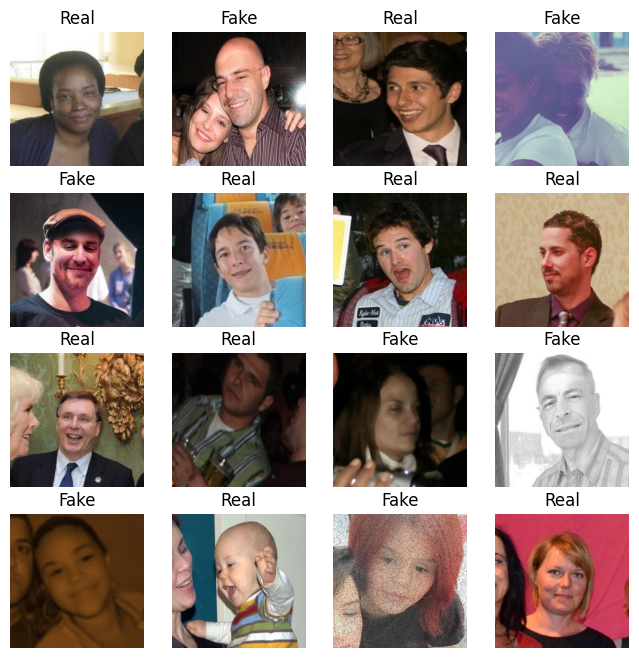

In [ ]:
show_image_grid(ds, "test")

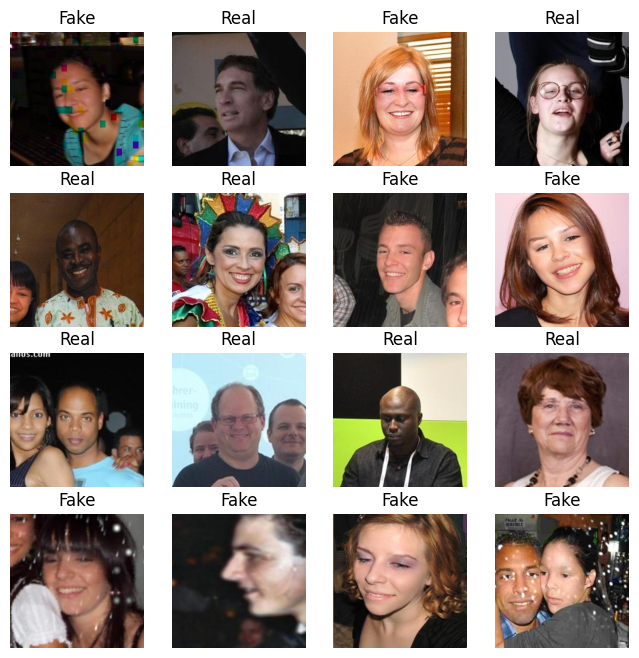

In [ ]:
show_image_grid(ds, "validation")

In [ ]:
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# the model name
model_name = "google/vit-base-patch16-224"
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = ViTForImageClassification.from_pretrained(model_name)

In [ ]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it
  # using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]
  return inputs

# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [ ]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
None


In [ ]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['Fake', 'Real']

In [ ]:
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

In [ ]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [ ]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb15fbd74e6ab91e3/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Fake",
    "1": "Real"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Fake": "0",
    "Real": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.40.0"
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--vit-base-patch16-224/snapshots/3f49326eb077187dfe1c2a2bb

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-deepfake", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


PyTorch: setting up devices


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated  Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [ ]:
# start training
trainer.train()

In [ ]:
trainer.evaluate(dataset["test"])

In [ ]:
# load the best model, change the checkpoint number to the best checkpoint
# if the last checkpoint is the best, then ignore this cell
best_checkpoint = 3000
# best_checkpoint = 150
model = ViTForImageClassification.from_pretrained(f"./vit-base-deepfake/checkpoint-{best_checkpoint}").to(device)
# model = ViTForImageClassification.from_pretrained(f"./vit-base-skin-cancer/checkpoint-{best_checkpoint}").to(device)

In [ ]:
def get_prediction(model, url_or_path):
  # load the image
  img = load_image(url_or_path)
  # preprocessing the image
  pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
  # perform inference
  output = model(pixel_values)
  # get the label id and return the class name
  return model.config.id2label[int(output.logits.softmax(dim=1).argmax())]

In [ ]:
get_prediction(best_model, "")

In [ ]:
# #code to create PART FOLDER

# import os
# import shutil
# import random

# # Define paths
# master_folder = '/content/drive/MyDrive/project1/dataset40k'
# train_folder = 'dataset10k/train'
# valid_folder = 'dataset10k/valid'
# test_folder = 'dataset10k/test'

# # Define the number of images for each split
# train_count = 10000
# valid_count = 2000
# test_count = 3000

# # Define subfolder names
# subfolders = ['Real', 'Fake']

# # Function to move files to the respective split folders
# def move_files(source_folder, dest_folder, count):
#     files = os.listdir(source_folder)
#     selected_files = random.sample(files, count)
#     for file in selected_files:
#         src = os.path.join(source_folder, file)
#         dest = os.path.join(dest_folder, file)
#         shutil.move(src, dest)

# # Create train, validation, and test folders
# for folder in [train_folder, valid_folder, test_folder]:
#     os.makedirs(os.path.join(folder, 'Real'), exist_ok=True)
#     os.makedirs(os.path.join(folder, 'Fake'), exist_ok=True)

# # Move files to train folder
# for subfolder in subfolders:
#     move_files(os.path.join(master_folder, subfolder), os.path.join(train_folder, subfolder), train_count)

# # Move files to validation folder
# for subfolder in subfolders:
#     move_files(os.path.join(master_folder, subfolder), os.path.join(valid_folder, subfolder), valid_count)

# # Move remaining files to test folder
# for subfolder in subfolders:
#     files = os.listdir(os.path.join(master_folder, subfolder))
#     for file in files:
#         src = os.path.join(master_folder, subfolder, file)
#         dest = os.path.join(test_folder, subfolder, file)
#         shutil.move(src, dest)


OSError: [Errno 5] Input/output error: '/content/drive/MyDrive/project1/dataset40k/Fake'

In [ ]:
# Function to print summary of folder structure
def print_folder_summary(folder):
    print(f"Summary of folder: {folder}")
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        num_files = len(os.listdir(subfolder_path))
        print(f"{subfolder}: {num_files} files")
    print()

# Print summary of train folder
print_folder_summary('/content/drive/MyDrive/project1/part/test')

# Print summary of validation folder
print_folder_summary('/content/drive/MyDrive/project1/part/train')

# Print summary of test folder
print_folder_summary('/content/drive/MyDrive/project1/part/valid')


Summary of folder: /content/drive/MyDrive/project1/part/test
Real: 2787 files
Fake: 2641 files

Summary of folder: /content/drive/MyDrive/project1/part/train
Real: 14000 files
Fake: 14000 files

Summary of folder: /content/drive/MyDrive/project1/part/valid
Real: 3000 files
Fake: 3000 files



**EXPLORATORY DATA ANALYSIS**

**Performing Exploratory Data Analysis (EDA)** on an image dataset can provide valuable insights into the characteristics and distribution of the data.

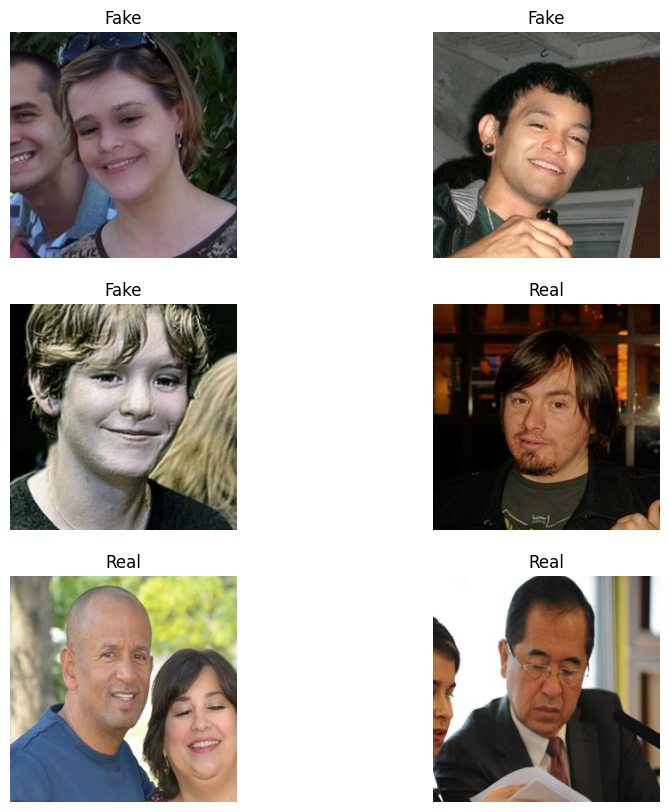

Subfolder: Fake
  Mean pixel value: 108.33193633524577
  Standard deviation: 71.2912541336665
  Min pixel value: 0
  Max pixel value: 255

Subfolder: Real
  Mean pixel value: 100.41998996988933
  Standard deviation: 69.4024419211387
  Min pixel value: 0
  Max pixel value: 255



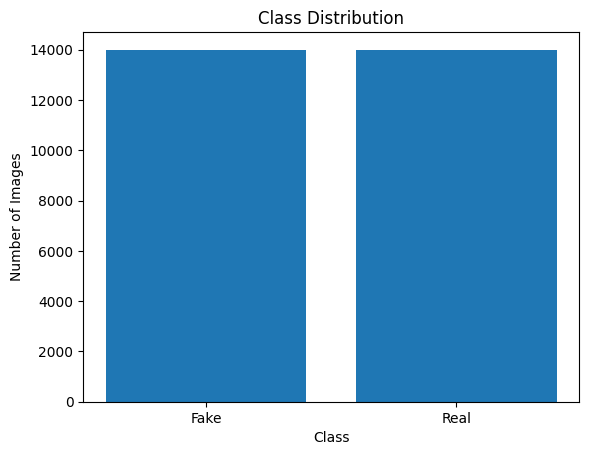

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
train_folder = '/content/drive/MyDrive/project1/part/train'
valid_folder = '/content/drive/MyDrive/project1/part/valid'
test_folder = '/content/drive/MyDrive/project1/part/test'

# Define sample size
sample_size = 500

# Function to display sample images
def display_sample_images(folder):
    plt.figure(figsize=(10, 10))
    subfolders = os.listdir(folder)
    for i, subfolder in enumerate(subfolders):
        subfolder_path = os.path.join(folder, subfolder)
        files = np.random.choice(os.listdir(subfolder_path), 3, replace=False)  # Select 3 random files
        for j, file in enumerate(files):
            img = Image.open(os.path.join(subfolder_path, file))
            plt.subplot(3, len(subfolders), i * 3 + j + 1)
            plt.imshow(img)
            plt.title(subfolder)
            plt.axis('off')
    plt.show()

# Function to calculate image statistics
def calculate_image_statistics(folder):
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        files = np.random.choice(os.listdir(subfolder_path), sample_size, replace=False)  # Select random files
        pixel_values = []
        for file in files:
            img = Image.open(os.path.join(subfolder_path, file))
            pixel_values.extend(np.array(img).flatten())
        pixel_values = np.array(pixel_values)
        print(f"Subfolder: {subfolder}")
        print(f"  Mean pixel value: {np.mean(pixel_values)}")
        print(f"  Standard deviation: {np.std(pixel_values)}")
        print(f"  Min pixel value: {np.min(pixel_values)}")
        print(f"  Max pixel value: {np.max(pixel_values)}")
        print()

# Function to plot class distribution
def plot_class_distribution(folder):
    subfolders = os.listdir(folder)
    class_counts = {}
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        class_counts[subfolder] = len(os.listdir(subfolder_path))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

# Function to plot image size distribution
def plot_image_size_distribution(folder):
    subfolders = os.listdir(folder)
    sizes = []
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        files = np.random.choice(os.listdir(subfolder_path), sample_size, replace=False)  # Select random files
        for file in files:
            img = Image.open(os.path.join(subfolder_path, file))
            sizes.append(img.size)
    sizes = np.array(sizes)
    plt.scatter(sizes[:, 0], sizes[:, 1])
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Size Distribution')
    plt.show()

# Display sample images
display_sample_images(train_folder)

# Calculate image statistics
calculate_image_statistics(train_folder)

# Plot class distribution
plot_class_distribution(train_folder)

# Plot image size distribution
plot_image_size_distribution(train_folder)


BASIC CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define paths
train_folder = '/content/drive/MyDrive/project1/part/train'
valid_folder = '/content/drive/MyDrive/project1/part/valid'
test_folder = '/content/drive/MyDrive/project1/part/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(255, 255),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(255, 255),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(255, 255),
    batch_size=32,
    class_mode='binary'
)

Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 5428 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
IMAGE_SIZE = (255, 255)
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 2

# # Define directories
# train_dir = '/content/drive/MyDrive/project1/Dataset/Train'
# validation_dir = '/content/drive/MyDrive/project1/Dataset/Validation'
# test_dir = '/content/drive/MyDrive/project1/Dataset/Test'

# Preprocess the data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    valid_folder,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # 1 output neuron for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)


Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Epoch 1/10
875/875 [==============================] - 403s 443ms/step - loss: 0.5276 - accuracy: 0.7437 - val_loss: 0.4382 - val_accuracy: 0.7981
Epoch 2/10
875/875 [==============================] - 199s 227ms/step - loss: 0.4001 - accuracy: 0.8179 - val_loss: 0.3750 - val_accuracy: 0.8359
Epoch 3/10
875/875 [==============================] - 184s 211ms/step - loss: 0.3239 - accuracy: 0.8575 - val_loss: 0.3307 - val_accuracy: 0.8526
Epoch 4/10
875/875 [==============================] - 197s 225ms/step - loss: 0.2443 - accuracy: 0.8971 - val_loss: 0.3283 - val_accuracy: 0.8710
Epoch 5/10
875/875 [==============================] - 185s 211ms/step - loss: 0.1666 - accuracy: 0.9333 - val_loss: 0.3506 - val_accuracy: 0.8676
Epoch 6/10
875/875 [==============================] - 192s 220ms/step - loss: 0.1066 - accuracy: 0.9606 - val_loss: 0.4351 - val_accuracy: 0.8645
Epoch 7/10
875/875 [===================

In [ ]:
model.save('deep_fake_model')

In [ ]:
from tensorflow.keras.models import load_model
loaded_model = load_model('deep_fake_model')

# 3. Test the model with a given image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((255, 255))  # Assuming your model expects input of size 224x224
    img = np.array(img) / 255.0  # Normalize pixel values
    return img.reshape(1, 255, 255, 3)  # Reshape for model input (assuming it's RGB)

image_path = '/content/drive/MyDrive/project1/part/test/Real/real_10003.jpg'  # Path to your test image
preprocessed_image = preprocess_image(image_path)
prediction = loaded_model.predict(preprocessed_image)

# Assuming your model predicts classes, you might want to decode the prediction
# For example, if your model is a classifier and predicts class probabilities
predicted_class = np.argmax(prediction)
print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 114ms/step
Predicted class: 0
